In [38]:
import numpy as np
import cv2
import pandas as pd
import PIL
import utm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import os

In [39]:
video_name = 'Help'
data = pd.read_fwf('data/head_tracking_data/Subject_6/' + video_name + '.txt', header=None)

data.columns = ['latitude', 'longitude']

cap = cv2.VideoCapture('data/video_files/' + video_name + '.mp4')

In [40]:
def start_end_point(lat, lon):
    start = [lon - 55, lat + 50]
    end = [lon + 55, lat - 50]
    if start[0] > 180:
        start[0] = start[0] - 360
    elif start[0] < -180:
        start[0] = start[0] + 360
    if start[1] > 80:
        start[1] = start[1] - 160
    elif start[1] < - 80:
        start[1] = start[1] + 160

    if end[0] > 180:
        end[0] = end[0] - 360
    elif end[0] < -180:
        end[0] = end[0] + 360
    if end[1] > 80:
        end[1] = end[1] - 160
    elif end[1] < - 80:
        end[1] = end[1] + 160

    return(start, end)

starting_points = []
ending_points = []

# Determine top left and bottom right UTM coordinates of the viewport
for i in range(len(data)):
    start, end = start_end_point(data.iloc[i]['latitude'], data.iloc[i]['longitude'])
    
    start_utm = utm.from_latlon(start[1], start[0])
    starting_points.append(start_utm[2:])
    
    end_utm = utm.from_latlon(end[1], end[0])
    ending_points.append(end_utm[2:])

starting_zones = pd.DataFrame(starting_points)
ending_zones = pd.DataFrame(ending_points)

In [41]:
# concatenate zones and zone bands to dataframe
coords = pd.concat([data, starting_zones, ending_zones],axis=1)
coords.columns = ['latitude', 'longitude', 's_zone', 's_band', 'e_zone', 'e_band']

In [42]:
# convert band-letters to numbers - issue exists because mercator zones omit the letters "I" and "O"
coords['ns_band'] = [ ord(x) - 64 for x in coords.s_band ]
coords['ne_band'] = [ ord(x) - 64 for x in coords.e_band ]

In [43]:
# Probably here we can work out the size of a tile
# Determine bins (for 4x4 tiling it will be 15 UTM zones and 6 UTM bands)
bins_zone = [i*15 for i in range(0,5)]
labels_zone = [i for i in range(1,5)]

bins_band = [i*6 for i in range(0,5)]
labels_band = [i for i in range(1,5)]

# Binning results
coords['s_bin_zone'] = pd.DataFrame(pd.cut(coords['s_zone'], bins=bins_zone, labels=labels_zone))
coords['s_bin_band'] = pd.DataFrame(pd.cut(coords['ns_band'], bins=bins_band, labels=labels_band))
coords['e_bin_zone'] = pd.DataFrame(pd.cut(coords['e_zone'], bins=bins_zone, labels=labels_zone))
coords['e_bin_band'] = pd.DataFrame(pd.cut(coords['ne_band'], bins=bins_band, labels=labels_band))

In [44]:
G = nx.DiGraph()
for i in range(len(coords)-1):

    prev_top_left_zone = (coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band'])
    prev_bottom_right_zone = (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])
    curr_top_left_zone = (coords.iloc[i+1]['s_bin_zone'], coords.iloc[i+1]['s_bin_band'])
    curr_bottom_right_zone = (coords.iloc[i+1]['e_bin_zone'], coords.iloc[i+1]['e_bin_band'])

    # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
    G.add_edge((prev_top_left_zone, prev_bottom_right_zone), (curr_top_left_zone, curr_bottom_right_zone))
    

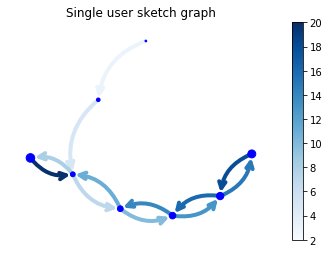

In [9]:
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [i / M  for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=16,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    connectionstyle="arc3,rad=0.3",
    width=4,
)
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
ax.set_axis_off()
plt.title('Single user sketch graph')
plt.show()


In [37]:
# Check whether amount of nodes corresponds with the amount of unique views in a data set
lst = []
for i in range(len(coords)):
    lst.append(((coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band']), (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])))

df = pd.DataFrame(lst)
df.columns = ['starts', 'ends']

no_uniques = len(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))
no_nodes = G.number_of_nodes()

print('Valid output:', no_uniques == no_nodes)
print('No of nodes:', no_nodes)
print('No of uniques:', no_uniques)
print(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))

Valid output: True
No of nodes: 8
No of uniques: 8
   starts    ends  count
0  (1, 4)  (2, 1)     19
1  (1, 4)  (3, 1)      2
2  (2, 4)  (3, 1)     11
3  (2, 4)  (3, 2)     86
4  (2, 4)  (4, 1)      5
5  (2, 4)  (4, 2)      2
6  (3, 4)  (4, 1)    486
7  (3, 4)  (4, 2)      3
